In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set(color_codes=True)
from tensorflow.examples.tutorials.mnist import input_data

ImportError: No module named 'seaborn'

In [2]:
XAVIER= tf.contrib.layers.xavier_initializer(uniform = True)
CONST = tf.constant_initializer(0.0)
NORMAL = tf.random_normal_initializer(mean = 0.0, stddev = 0.5)
def images_print(images, save_name=None):
    batch = len(images)
    row = int(np.sqrt(batch))
    if row*row == batch:
        images_r = np.reshape(images, [row,row, 28,28])
        imap = np.transpose(images_r, [0,2,1,3])
        imap_r = np.reshape(imap, [28*row, 28*row])
        fig = plt.figure(figsize=(5, 5))
        plt.imshow(imap_r, cmap='gray')
        plt.axis('off')
        if save_name is None:
            plt.show()        
        else:
            plt.savefig(save_name)
            plt.close(fig)
        return
    
def linear(input, output_dim, scope=None):
    '''
    operation :
        input :
            matrixes(a*b) dim = 2
        input.get_shape() => (a, b)
        input.get_shape()[1] => b
        w => b*output_dim
        tf.matmul(input, w ) => a * output_dim
        b= > output_dim
    return :
        matrixes(a*output_dim) 
    '''
    
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=XAVIER)
        b = tf.get_variable('b', [output_dim], initializer=NORMAL)
        return tf.matmul(input, w) + b

def get_shape(tensor):
    return tensor.get_shape().as_list()

def clip(x, vmin = 1e-10, vmax = 1-1e-10):
    return tf.clip_by_value(x, clip_value_max= vmax, clip_value_min= vmin)

def change_var(sess, var, discount):
    new_var = sess.run(var)*discount
    sess.run(tf.assign(var, new_var))

def print_keys(string):
    i=0
    while True:
        try:
            print("{} : {}".format(tf.get_collection(string)[i].op.name, 
                                   get_shape(tf.get_collection(string)[i])))
            i+=1
        except IndexError:
            break 

In [ ]:
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

In [ ]:
train = {}
test = {}
val = {}
train['input'] = mnist.train.images
train['output'] = mnist.train.labels
test['input'] = mnist.test.images
test['output'] = mnist.test.labels
val['input'] = mnist.validation.images
val['output'] = mnist.validation.labels

In [4]:
batch_size = 100
batch_num = 550
epoch = 20
rnn_size = 100

In [5]:
x = tf.placeholder(tf.float32, shape= [batch_size, 27, 28])
y = tf.placeholder(tf.float32, shape= [batch_size, 27, 28])

x_t = tf.transpose(x, [1,0,2])
x_r = tf.reshape(x_t, [-1, 28])
x_split = tf.split(x_r, 27, axis = 0)

with tf.variable_scope("rnn") as scope:
    lstm_cell = tf.contrib.rnn.LSTMCell(rnn_size)
    wrapped_cell = tf.contrib.rnn.OutputProjectionWrapper(lstm_cell, 28)
    state = wrapped_cell.zero_state(batch_size, tf.float32)
    outputs =[]
    flag = 0
    for input_ in x_split:
        if flag==0:
            flag = 1
        else :
            scope.reuse_variables()
        output, state = wrapped_cell(input_, state)
        outputs.append(output)
outputs_stack = tf.stack(outputs)
outputs_t = tf.transpose(tf.sigmoid(outputs_stack), [1, 0 , 2])
error = tf.reduce_mean(tf.square(outputs_t-y))
optimizer = tf.train.AdamOptimizer().minimize(error)

# Restore

In [6]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, './save/model')

# Save

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for e in range(epoch):
    index = np.arange(len(train['input']))
    np.random.shuffle(index)
    trX = train['input'][index]
    epoch_loss = 0 
    for batch in range(batch_num):
        train_batch = trX[batch*batch_size:(batch+1)*batch_size]
        train_batch_r = np.reshape(train_batch, [batch_size, 28, 28])
        input_batch = np.transpose(np.transpose(train_batch_r, [1, 0, 2])[:-1], [1,0,2])
        output_batch = np.transpose(np.transpose(train_batch_r, [1, 0, 2])[1:], [1,0,2])
        train_feed_dict = {x : input_batch, y : output_batch}
        _, cost = sess.run([optimizer, error], feed_dict=train_feed_dict)
        epoch_loss += cost
    print('Epoch({}/{}) cost = {}'.format(e+1, epoch, epoch_loss))
saver = tf.train.Saver()
saver.save(sess, './save/model')

Epoch(1/20) cost = 32.33557625673711
Epoch(2/20) cost = 13.942732561379671
Epoch(3/20) cost = 11.265160931274295
Epoch(4/20) cost = 10.28910299576819
Epoch(5/20) cost = 9.738781850785017
Epoch(6/20) cost = 9.377491219900548
Epoch(7/20) cost = 9.105187994427979
Epoch(8/20) cost = 8.886138005182147
Epoch(9/20) cost = 8.698262969963253
Epoch(10/20) cost = 8.51372071262449
Epoch(11/20) cost = 8.368328304030001
Epoch(12/20) cost = 8.253233629278839
Epoch(13/20) cost = 8.121148313395679
Epoch(14/20) cost = 8.006905706599355
Epoch(15/20) cost = 7.913220424205065
Epoch(16/20) cost = 7.80715283472091
Epoch(17/20) cost = 7.722877790220082
Epoch(18/20) cost = 7.632838002406061
Epoch(19/20) cost = 7.559707438573241
Epoch(20/20) cost = 7.480546614155173


'./save/model'

In [8]:
def image_generator(images, keep_num = 14):
    image_r = np.reshape(images, [batch_size, 28, 28])
    image_t = np.transpose(image_r, [1,0,2])
    image_restore = np.zeros((batch_size, 28, 28))
    for i in range(batch_size):
        for j in range(keep_num):
            for k in range(28):
                image_restore[i][j][k] = image_r[i][j][k] 
    with tf.variable_scope("rnn") as scope:
        for i in range(27):
            if i == 0 :
                state = wrapped_cell.zero_state(batch_size=batch_size, dtype=tf.float32)
            scope.reuse_variables()
            if i< keep_num-1:
                restored_, state = wrapped_cell(tf.convert_to_tensor(image_t[i]), state) 
            else:
                restored_, state = wrapped_cell(tf.sigmoid(restored_), state) 
                restored = sess.run(tf.sigmoid(restored_))
                for j in range(batch_size):
                    for k in range(28):
                        image_restore[j][i+1][k] = restored[j][k]
    return image_restore

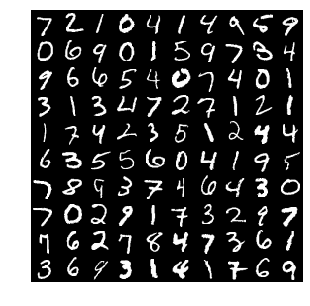

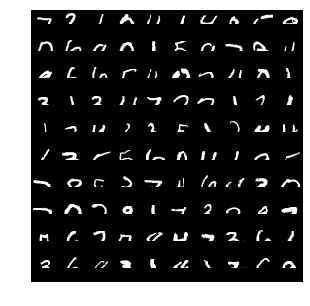

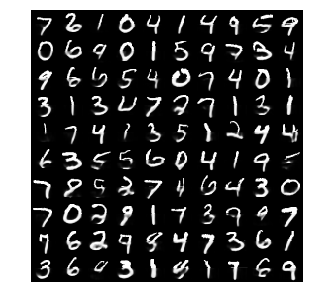

In [10]:
start = 0
image_sample = np.reshape(test['input'][start:start+batch_size], [batch_size, 28, 28])

keep_row = 14
image_clip = np.zeros((batch_size, 28, 28))
for i in range(batch_size):
    for j in range(keep_row):
        for k in range(28):
            image_clip[i][j][k] = image_sample[i][j][k]
image_fake = image_generator(image_sample, keep_row)
images_print(image_sample)
images_print(image_clip)
images_print(image_fake)